In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
project_root = Path().resolve().parent
metadata_path = project_root / "metadata" / "metadata_images.csv"
data_raw_dir = project_root / "data" / "raw"


In [3]:
df = pd.read_csv(metadata_path)
print(df.head())

                                image_path timepoint     group  subject_id  \
0  1 Week/Combined/Combined 1/Slice 18.png    1 Week  Combined  Combined 1   
1  1 Week/Combined/Combined 1/Slice 19.png    1 Week  Combined  Combined 1   
2  1 Week/Combined/Combined 1/Slice 20.png    1 Week  Combined  Combined 1   
3  1 Week/Combined/Combined 1/Slice 21.png    1 Week  Combined  Combined 1   
4  1 Week/Combined/Combined 1/Slice 22.png    1 Week  Combined  Combined 1   

   slice_idx  has_label  
0         18      False  
1         19      False  
2         20      False  
3         21      False  
4         22      False  


In [4]:
print(df['timepoint'].value_counts())
print(df['group'].value_counts())
print(df['subject_id'].nunique())

timepoint
48 Hours    246
24 Hours    242
1 Week      210
3 Weeks     127
Name: count, dtype: int64
group
GOT         226
GPT         215
Control     205
Combined    179
Name: count, dtype: int64
45


## Size check

Summary of slices per subject/timepoint:
count    119.000000
mean       6.932773
std        1.424549
min        4.000000
25%        6.000000
50%        7.000000
75%        8.000000
max       11.000000
Name: n_slices, dtype: float64

IQR bounds -> lower: 3.0, upper: 11.0
Low outliers (too few slices): 0
High outliers (too many slices): 0

Examples - lowest counts:
Empty DataFrame
Columns: [subject_id, timepoint, n_slices]
Index: []

Examples - highest counts:
Empty DataFrame
Columns: [subject_id, timepoint, n_slices]
Index: []

Subjects missing any expected timepoints: 35
 subject_id                     timepoint                    timepoints            missing_timepoints
 Combined 7  [1 Week, 24 Hours, 48 Hours]  [1 Week, 24 Hours, 48 Hours]                     [3 Weeks]
 Combined 8  [1 Week, 24 Hours, 48 Hours]  [1 Week, 24 Hours, 48 Hours]                     [3 Weeks]
  Control 1 [24 Hours, 3 Weeks, 48 Hours] [24 Hours, 3 Weeks, 48 Hours]                      [1 Week]
Control 5 2   

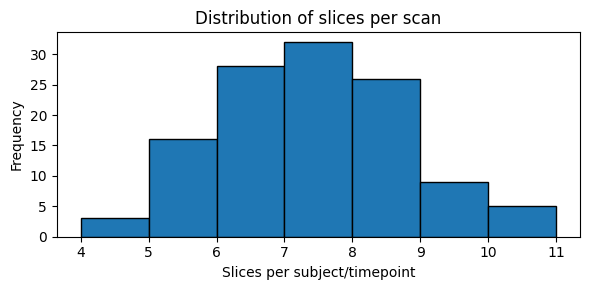

In [5]:
# New cell: check slices per subject/timepoint and flag deficiencies/unusual subjects
counts = df.groupby(['subject_id', 'timepoint']).size().reset_index(name='n_slices')

print("Summary of slices per subject/timepoint:")
print(counts['n_slices'].describe())

# IQR-based outlier detection
Q1 = counts['n_slices'].quantile(0.25)
Q3 = counts['n_slices'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

low_outliers = counts[counts['n_slices'] < lower_bound].sort_values('n_slices')
high_outliers = counts[counts['n_slices'] > upper_bound].sort_values('n_slices', ascending=False)

print(f"\nIQR bounds -> lower: {lower_bound:.1f}, upper: {upper_bound:.1f}")
print(f"Low outliers (too few slices): {len(low_outliers)}")
print(f"High outliers (too many slices): {len(high_outliers)}")

print("\nExamples - lowest counts:")
print(low_outliers.head(10).to_string(index=False))
print("\nExamples - highest counts:")
print(high_outliers.head(10).to_string(index=False))

# Check missing timepoints per subject
expected_timepoints = sorted(df['timepoint'].unique())
tp_per_subject = df.groupby('subject_id')['timepoint'].unique().reset_index()
tp_per_subject['timepoints'] = tp_per_subject['timepoint'].apply(list)
tp_per_subject['missing_timepoints'] = tp_per_subject['timepoints'].apply(lambda tps: [t for t in expected_timepoints if t not in tps])
missing_tp = tp_per_subject[tp_per_subject['missing_timepoints'].map(len) > 0]

print(f"\nSubjects missing any expected timepoints: {len(missing_tp)}")
if len(missing_tp):
    print(missing_tp.head(10).to_string(index=False))

# Inconsistency across a subject's timepoints (min vs max slices)
per_subject_stats = counts.groupby('subject_id')['n_slices'].agg(['min', 'max', 'mean']).reset_index()
per_subject_stats['diff'] = per_subject_stats['max'] - per_subject_stats['min']
inconsistent_subjects = per_subject_stats.sort_values('diff', ascending=False).head(10)

print("\nTop subjects with inconsistent slice counts across timepoints:")
print(inconsistent_subjects.to_string(index=False))

# Quick histogram
plt.figure(figsize=(6,3))
plt.hist(counts['n_slices'], bins=7, color='C0', edgecolor='k')
plt.xlabel('Slices per subject/timepoint')
plt.ylabel('Frequency')
plt.title('Distribution of slices per scan')
plt.tight_layout()
plt.show()

**mini conclutions for size check:**
- **Conclusion 1:** The data is uniform and stable in terms of the number of slices
There are no real outliers, the distribution is centered around 7 slices.
The main meaning is that we will not have to discard scans or do filtering at this stage.
- **Conclusion 2:** There are some subjects with differences of 2–3 slices between different times
in the data diff = 3
This is not unusual, but a note should be made:
This means that the scanner did not always cut at exactly the same depth, the model will deal with this but it will add variability to the data.

In [6]:
#  metadata consistency checks
import hashlib
from collections import defaultdict
from pathlib import Path

CHUNK = 2 ** 20  # 1 MiB


def _file_hash(p: Path) -> str:
    h = hashlib.sha256()
    with p.open("rb") as f:
        for chunk in iter(lambda: f.read(CHUNK), b""):
            h.update(chunk)
    return h.hexdigest()


def _resolve_path_value(val):
    if pd.isna(val):
        return None
    p = Path(str(val))
    if not p.is_absolute():
        p = data_raw_dir / p
    return p


# Identify which column in metadata likely holds the path/filename
path_candidates = ["file_path", "filepath", "relative_path", "path", "image_path", "filename", "file"]
meta_path_col = None
cols_lower = [c.lower() for c in df.columns]
for c in path_candidates:
    if c in cols_lower:
        # find original-cased column name
        meta_path_col = df.columns[cols_lower.index(c)]
        break

if meta_path_col is None:
    print("No recognized file/path column in metadata. Expected one of:", path_candidates)
else:
    print("Using metadata column for file paths:", meta_path_col)
    # Resolve paths for every metadata row
    resolved_paths = []
    for i, row in df.iterrows():
        val = row[meta_path_col]
        p = _resolve_path_value(val)
        resolved_paths.append(p)
    df['_resolved_path'] = resolved_paths

    # 1) Missing files (metadata -> raw)
    missing = [(i, str(p)) for i, p in enumerate(df['_resolved_path']) if (p is None or not p.exists())]
    print(f"\nMetadata rows pointing to missing files: {len(missing)}")
    if missing:
        print("Examples (row_index, resolved_path):")
        for ex in missing[:10]:
            print(" ", ex)

    # 2) Broken symlinks
    broken_symlinks = []
    for i, p in enumerate(df['_resolved_path']):
        if p is None:
            continue
        try:
            if p.is_symlink() and not p.exists():
                broken_symlinks.append((i, str(p)))
        except Exception:
            # on some systems is_symlink may raise for non-existing parents
            if p.exists() is False and p.is_symlink():
                broken_symlinks.append((i, str(p)))
    print(f"\nBroken symlinks referenced by metadata: {len(broken_symlinks)}")
    if broken_symlinks:
        for ex in broken_symlinks[:10]:
            print(" ", ex)

    # 3) Metadata duplicate rows (same resolved path repeated)
    path_counts = df['_resolved_path'].value_counts(dropna=True)
    duplicates_in_metadata = [str(p) for p, cnt in path_counts.items() if cnt > 1]
    print(f"\nMetadata contains identical path listed multiple times: {len(duplicates_in_metadata)} unique paths repeated")
    if duplicates_in_metadata:
        for ex in duplicates_in_metadata[:10]:
            print(" ", ex)

    # 4) Are there files with identical content under different names/paths in data/raw?
    print("\nScanning raw data files to detect identical content under different paths (this may take time)...")
    if not data_raw_dir.exists():
        print("Raw data directory does not exist:", data_raw_dir)
    else:
        hash_map = defaultdict(list)
        for p in data_raw_dir.rglob("*"):
            if p.is_file():
                try:
                    h = _file_hash(p)
                except Exception as e:
                    print("  Skipping file (read error):", p, "->", e)
                    continue
                hash_map[h].append(p)

        duplicate_content_groups = [paths for paths in hash_map.values() if len(paths) > 1]
        print(f"Found {len(duplicate_content_groups)} groups of files with identical content (different paths/names).")
        if duplicate_content_groups:
            print("Examples (showing up to 5 groups):")
            for group in duplicate_content_groups[:5]:
                print(" -")
                for p in group:
                    print("    ", p)

    # 5) Any metadata rows pointing outside data/raw (for relative paths we require they live under data/raw)
    outside = []
    try:
        raw_resolved = data_raw_dir.resolve()
        for i, p in enumerate(df['_resolved_path']):
            if p is None:
                continue
            try:
                rp = p.resolve()
            except Exception:
                rp = p
            if raw_resolved not in rp.parents and rp != raw_resolved:
                outside.append((i, str(p)))
    except Exception:
        outside = []
    print(f"\nMetadata rows that resolve to paths outside data/raw: {len(outside)}")
    if outside:
        for ex in outside[:10]:
            print(" ", ex)

    # Compact summary
    print("\nSummary:")
    print(" - metadata rows:", len(df))
    print(" - missing files referenced:", len(missing))
    print(" - broken symlinks:", len(broken_symlinks))
    print(" - duplicated metadata paths:", len(duplicates_in_metadata))
    print(" - identical-content files under raw (dup groups):", len(duplicate_content_groups))
    print(" - metadata rows resolving outside data/raw:", len(outside))

Using metadata column for file paths: image_path

Metadata rows pointing to missing files: 1
Examples (row_index, resolved_path):
  (0, '/Users/jonatanbuga/Desktop/MRI-Project/data/raw/1 Week/Combined/Combined 1/Slice 18.png')

Broken symlinks referenced by metadata: 0

Metadata contains identical path listed multiple times: 0 unique paths repeated

Scanning raw data files to detect identical content under different paths (this may take time)...
Found 0 groups of files with identical content (different paths/names).

Metadata rows that resolve to paths outside data/raw: 0

Summary:
 - metadata rows: 825
 - missing files referenced: 1
 - broken symlinks: 0
 - duplicated metadata paths: 0
 - identical-content files under raw (dup groups): 0
 - metadata rows resolving outside data/raw: 0


### Data Consistency Findings
During metadata-to-raw validation, 825 MRI slice files were checked.
Only one file was missing from disk, corresponding to:
Combined/1 Week/Combined 1/Slice 18.png.
No duplicated metadata entries, no duplicated content across files, no broken symlinks, and no file paths pointing outside the expected data/raw structure were detected.

**Conclusion:**
The dataset is extremely clean and structurally consistent.
The missing file represents ~0.12% of the data and does not indicate a structural issue.
This dataset is safe for downstream processing and training, with no need for additional cleaning steps.

## Visualization by groups and times

Global mean(img_mean)=30.15, std(img_mean)=5.48
Thresholds -> dark: 30.00, flat(std) < 5.00, discontinuity > 10.96


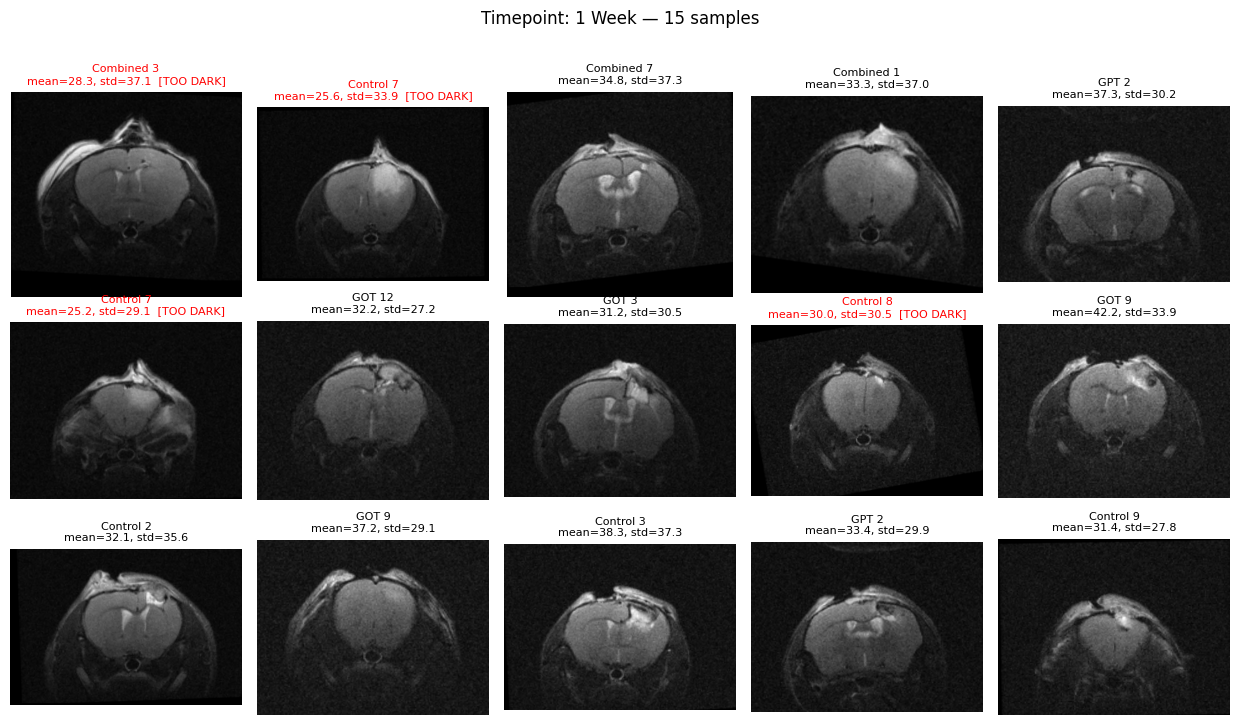

Timepoint 1 Week: flagged (dark/flat) = 4/15


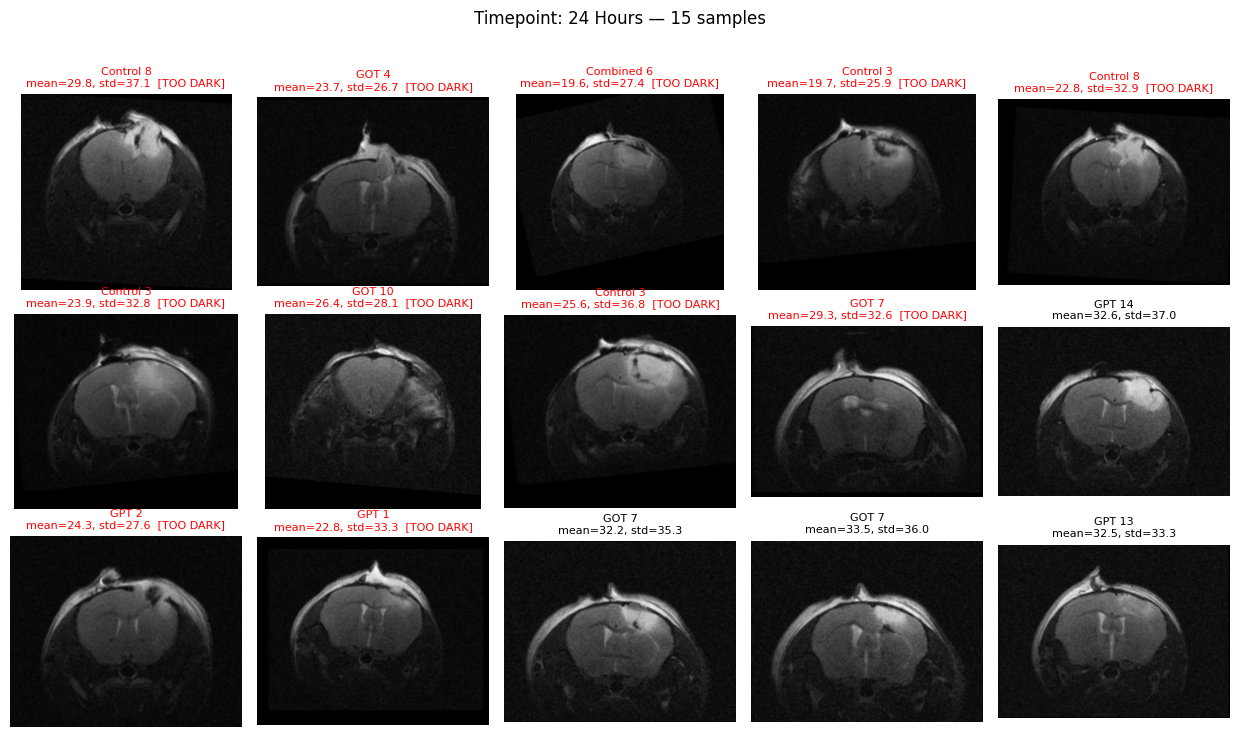

Timepoint 24 Hours: flagged (dark/flat) = 11/15


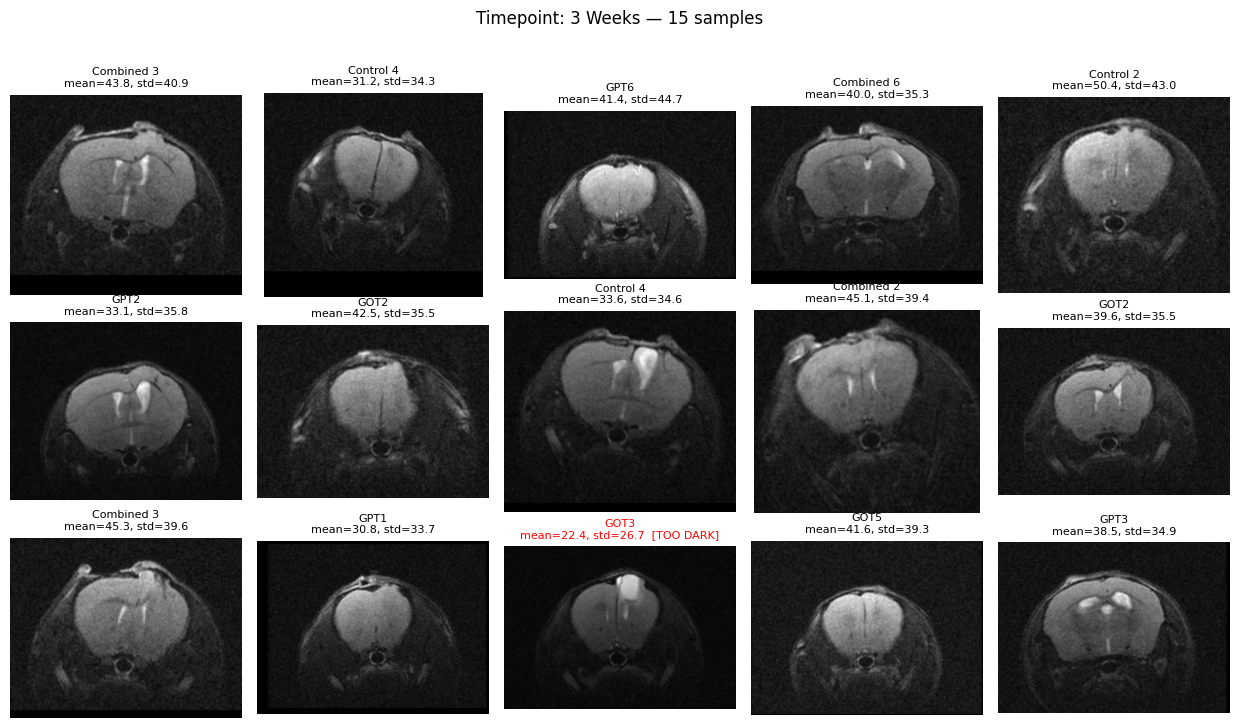

Timepoint 3 Weeks: flagged (dark/flat) = 1/15


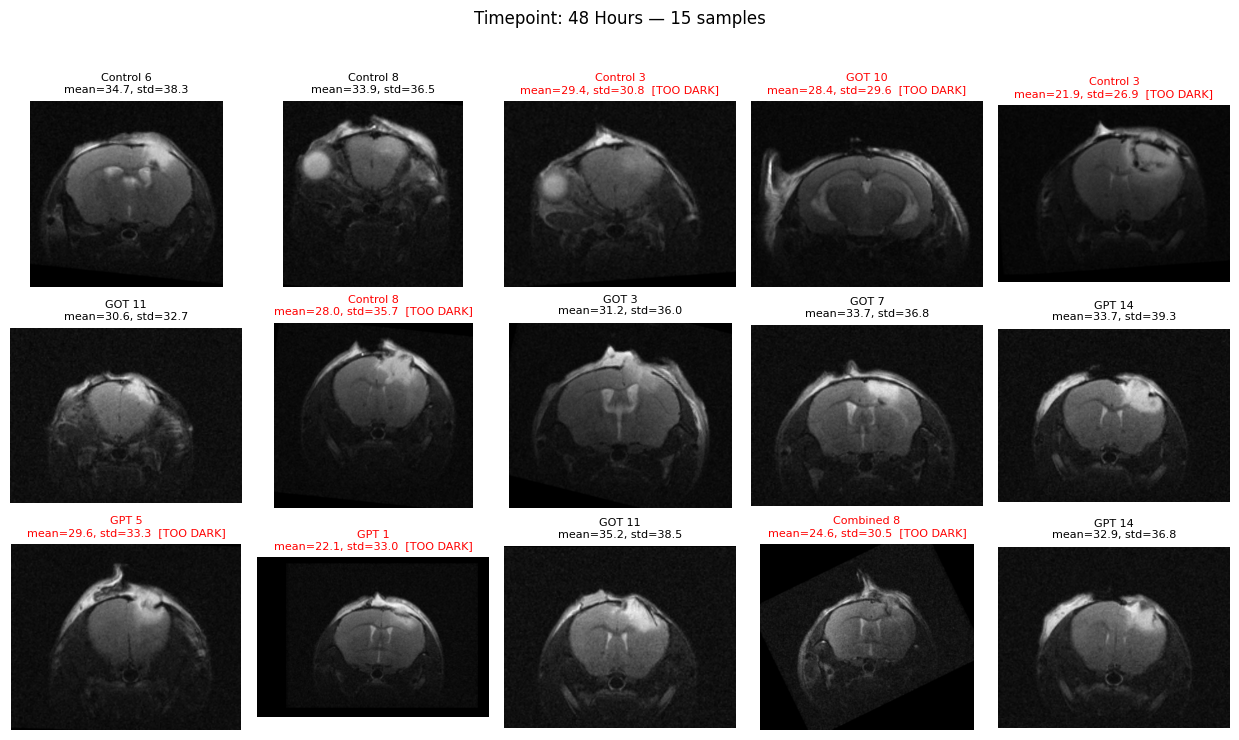

Timepoint 48 Hours: flagged (dark/flat) = 7/15


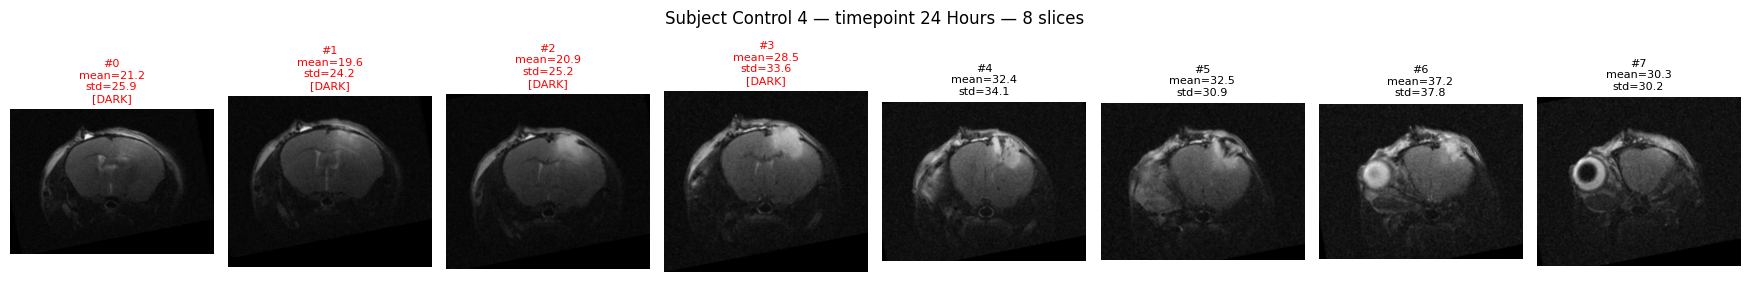

Subject Control 4: no large adjacent-slice discontinuities detected (checked up to 8 slices).


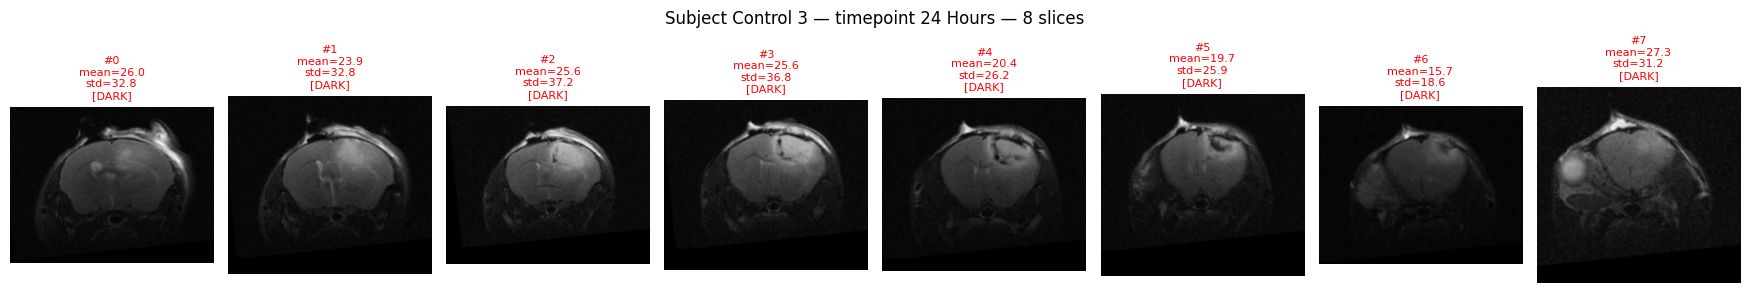

Subject Control 3 continuity issues (adjacent slice mean jumps > 11.0):
  slice#6 mean=15.7 -> slice#7 mean=27.3


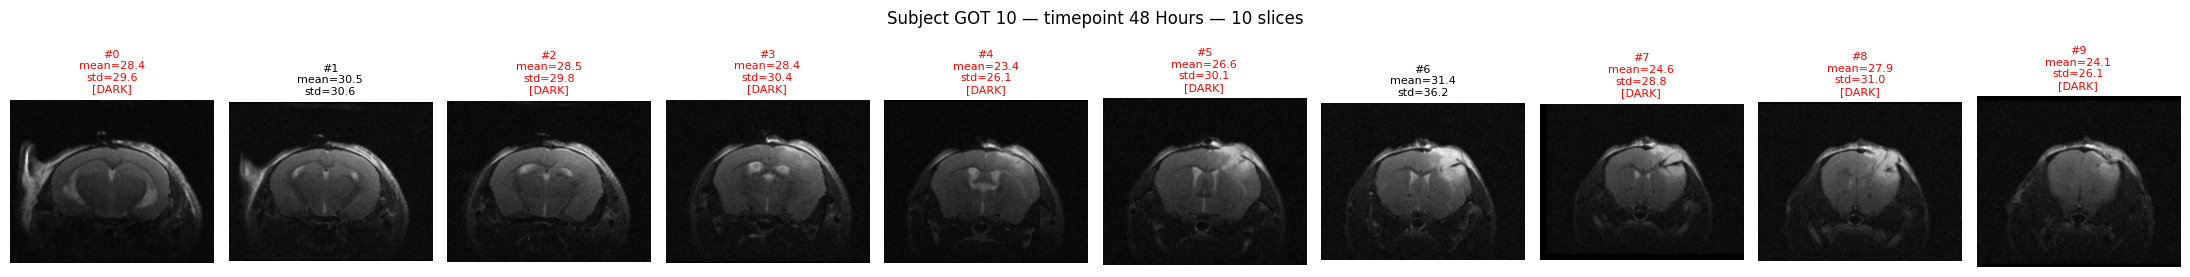

Subject GOT 10: no large adjacent-slice discontinuities detected (checked up to 10 slices).


In [7]:
# visualize samples per timepoint and check slice continuity / dark/flat images
import re
import random
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# configurable
n_samples_per_timepoint = 15
cols = 5
max_subject_slice_plots = 10  # per subject/timepoint

# resolve metadata file column (reuse previous candidate list)
path_candidates = ["file_path", "filepath", "relative_path", "path", "image_path", "filename", "file"]
cols_lower = [c.lower() for c in df.columns]
meta_path_col = None
for c in path_candidates:
    if c in cols_lower:
        meta_path_col = df.columns[cols_lower.index(c)]
        break
if meta_path_col is None:
    raise RuntimeError("No recognized file/path column in metadata. Add one of: " + ", ".join(path_candidates))

# ensure df['_resolved_path'] exists
if "_resolved_path" not in df.columns:
    def _resolve_path_value(val):
        if pd.isna(val):
            return None
        p = Path(str(val))
        if not p.is_absolute():
            p = data_raw_dir / p
        return p
    df["_resolved_path"] = df[meta_path_col].apply(_resolve_path_value)

# compute basic intensity stats for every image row if not already present
if "img_mean" not in df.columns or "img_std" not in df.columns:
    img_min_list, img_max_list, img_mean_list, img_std_list = [], [], [], []
    for i, p in enumerate(df["_resolved_path"]):
        if p is None or not p.exists():
            img_min_list.append(np.nan); img_max_list.append(np.nan)
            img_mean_list.append(np.nan); img_std_list.append(np.nan)
            continue
        try:
            im = Image.open(p).convert("L")
            a = np.asarray(im, dtype=np.float32)
            img_min_list.append(float(np.nanmin(a)))
            img_max_list.append(float(np.nanmax(a)))
            img_mean_list.append(float(np.nanmean(a)))
            img_std_list.append(float(np.nanstd(a, ddof=0)))
        except Exception:
            img_min_list.append(np.nan); img_max_list.append(np.nan)
            img_mean_list.append(np.nan); img_std_list.append(np.nan)
    df["img_min"] = img_min_list
    df["img_max"] = img_max_list
    df["img_mean"] = img_mean_list
    df["img_std"] = img_std_list

# global summary stats used to set adaptive thresholds
global_mean = float(np.nanmean(df["img_mean"]))
global_std = float(np.nanstd(df["img_mean"]))
dark_thresh = max(30.0, global_mean - 2 * global_std)     # absolute or relative
flat_thresh = max(5.0, global_std * 0.25)
discontinuity_thresh = max(10.0, 2 * global_std)

print(f"Global mean(img_mean)={global_mean:.2f}, std(img_mean)={global_std:.2f}")
print(f"Thresholds -> dark: {dark_thresh:.2f}, flat(std) < {flat_thresh:.2f}, discontinuity > {discontinuity_thresh:.2f}")

# helper to load and return image array (safe)
def load_gray(p):
    try:
        return np.asarray(Image.open(p).convert("L"), dtype=np.float32)
    except Exception:
        return None

# Visualize samples per timepoint
timepoints = sorted(df["timepoint"].dropna().unique())
for tp in timepoints:
    subset = df[df["timepoint"] == tp].dropna(subset=["_resolved_path"])
    if subset.empty:
        continue
    n = min(n_samples_per_timepoint, len(subset))
    sample = subset.sample(n=n, random_state=0) if len(subset) > n else subset
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten() if n > 1 else [axes]
    fig.suptitle(f"Timepoint: {tp} — {n} samples", fontsize=12)
    flagged_count = 0
    for ax_idx, (i, row) in enumerate(sample.iterrows()):
        ax = axes[ax_idx]
        p = row["_resolved_path"]
        a = load_gray(p)
        if a is None:
            ax.text(0.5, 0.5, "read error", ha="center")
            ax.axis("off")
            continue
        ax.imshow(a, cmap="gray", vmin=0, vmax=255)
        title = f"{row.get('subject_id','')}\nmean={row['img_mean']:.1f}, std={row['img_std']:.1f}"
        # flag dark or flat
        notes = []
        if row["img_mean"] < dark_thresh:
            notes.append("TOO DARK")
        if row["img_std"] < flat_thresh:
            notes.append("FLAT")
        if notes:
            flagged_count += 1
            title += "  [" + ",".join(notes) + "]"
            ax.set_title(title, color="red", fontsize=8)
        else:
            ax.set_title(title, fontsize=8)
        ax.axis("off")
    # hide unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print(f"Timepoint {tp}: flagged (dark/flat) = {flagged_count}/{n}")

# Visualize slices for a few subjects to inspect anatomical continuity
# pick top subjects by number of slices available
subject_counts = df.groupby("subject_id")["_resolved_path"].count().sort_values(ascending=False)
top_subjects = subject_counts.head(3).index.tolist()

def _natural_sort_key(s):
    parts = re.split(r'(\d+)', s)
    return [int(p) if p.isdigit() else p.lower() for p in parts]

for subj in top_subjects:
    subj_rows = df[df["subject_id"] == subj].dropna(subset=["_resolved_path"])
    if subj_rows.empty:
        continue
    # choose the timepoint with most slices for this subject
    tp_choice = subj_rows["timepoint"].value_counts().idxmax()
    rows_tp = subj_rows[subj_rows["timepoint"] == tp_choice].copy()
    # sort by filename heuristically (natural sort)
    rows_tp["_name"] = rows_tp["_resolved_path"].apply(lambda p: p.name)
    rows_tp = rows_tp.sort_values("_name", key=lambda s: s.map(_natural_sort_key))
    n_plot = min(len(rows_tp), max_subject_slice_plots)
    rows_tp = rows_tp.head(n_plot)
    fig, axes = plt.subplots(1, n_plot, figsize=(n_plot * 2.2, 3))
    if n_plot == 1:
        axes = [axes]
    fig.suptitle(f"Subject {subj} — timepoint {tp_choice} — {n_plot} slices", fontsize=12)
    continuous_issues = []
    prev_mean = None
    for idx, ((i, row), ax) in enumerate(zip(rows_tp.iterrows(), axes)):
        p = row["_resolved_path"]
        a = load_gray(p)
        if a is None:
            ax.text(0.5, 0.5, "read error", ha="center")
            ax.axis("off")
            continue
        ax.imshow(a, cmap="gray", vmin=0, vmax=255)
        mean = row["img_mean"]
        std = row["img_std"]
        title = f"#{idx}\nmean={mean:.1f}\nstd={std:.1f}"
        notes = []
        if mean < dark_thresh:
            notes.append("DARK")
        if std < flat_thresh:
            notes.append("FLAT")
        if notes:
            title += "\n[" + ",".join(notes) + "]"
            ax.set_title(title, color="red", fontsize=8)
        else:
            ax.set_title(title, fontsize=8)
        ax.axis("off")
        if prev_mean is not None:
            if abs(mean - prev_mean) > discontinuity_thresh:
                continuous_issues.append((idx-1, idx, prev_mean, mean))
        prev_mean = mean
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
    if continuous_issues:
        print(f"Subject {subj} continuity issues (adjacent slice mean jumps > {discontinuity_thresh:.1f}):")
        for a,b,pm,cm in continuous_issues:
            print(f"  slice#{a} mean={pm:.1f} -> slice#{b} mean={cm:.1f}")
    else:
        print(f"Subject {subj}: no large adjacent-slice discontinuities detected (checked up to {n_plot} slices).")

### summery 
1. There is a systematic difference in brightness level between time points

* Early (24h, some 48h) - many more “too dark” images.

* Late (1w, 3w) - most images in reasonable brightness range.
This could be related to the scanning protocol, instrument tuning, or the windowing was different at different times.
    - ***How to calculate brightness statistics***
        Global brightness statistics
        global mean(img_mean) ≈ 30.2, global std(img_mean) ≈ 5.5.
        Threshold setting - “too dark” = mean < 30
2. Anatomical continuity between slices is generally good
The majority of subjects examined appear to be anatomically and mean intensity continuous.
There are a few individual slices with unusual brightness (such as Control 3 slice#6) - they should be noted, but this is not a sweeping pattern.

***Conclutions***
* Conclusion 1 - Intensity normalization is a MUST in preprocessing.
    Because the overall brightness varies strongly between timepoints (especially the darker 24h/48h), in preprocessing we will want to do a per-image or per-scan normalization
    e.g.:
    - z-score for each image.
    - normalization to [0,1].
        
**This will reduce the “technical” difference between dark/bright images and help the model focus on the shape of the edema rather than the intensity of the illumination.**

## Analytical – quantitative measurements

Using metadata column: image_path

Rows with missing files: 1
Examples: [(0, '/Users/jonatanbuga/Desktop/MRI-Project/data/raw/1 Week/Combined/Combined 1/Slice 18.png')]
Rows with image read errors: 0

Aggregate intensity stats per (group, timepoint):
   group timepoint  n_images  mean_of_means  std_of_means  median_of_means  mean_img_std  min_of_mins  max_of_maxs
Combined    1 Week        43         30.524         3.991           30.179        34.452        0.000      254.000
Combined  24 Hours        55         27.963         4.170           28.150        32.457        0.000      255.000
Combined   3 Weeks        30         33.726         8.363           33.870        33.376        0.000      254.000
Combined  48 Hours        50         26.886         4.620           25.516        32.548        0.000      254.000
 Control    1 Week        53         32.298         4.615           32.723        32.570        0.000      254.000
 Control  24 Hours        59         25.849         5.335  

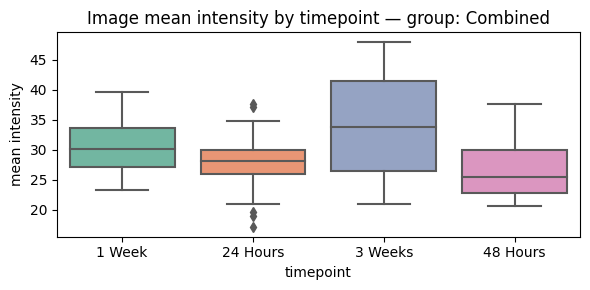

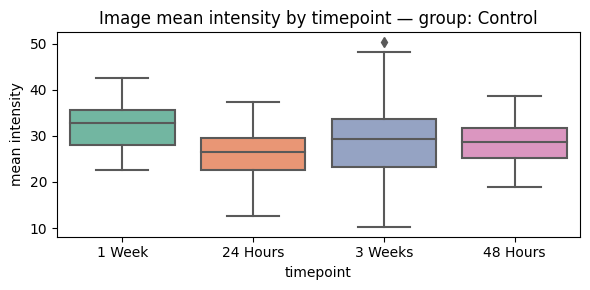

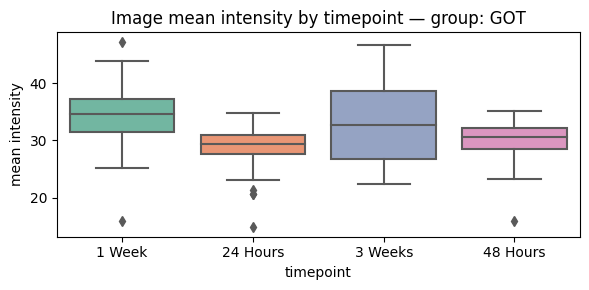

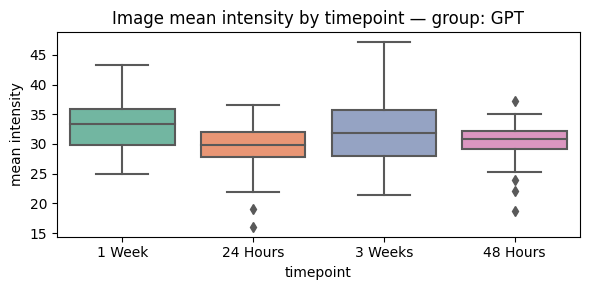

In [11]:
# intensity distribution checks (min/max/mean/std per image, compare timepoints, detect differences)
from PIL import Image, UnidentifiedImageError
import numpy as np
from collections import defaultdict
import math

# Find metadata column that points to image files (re-uses earlier candidate list)
path_candidates = ["file_path", "filepath", "relative_path", "path", "image_path", "filename", "file"]
cols_lower = [c.lower() for c in df.columns]
meta_path_col = None
for c in path_candidates:
    if c in cols_lower:
        meta_path_col = df.columns[cols_lower.index(c)]
        break

if meta_path_col is None:
    print("No recognized file/path column found in metadata. Add one of:", path_candidates)
else:
    print("Using metadata column:", meta_path_col)
    stats = []
    missing_rows = []
    read_errors = []

    for i, row in df.iterrows():
        val = row[meta_path_col]
        if pd.isna(val):
            missing_rows.append((i, "<NA>"))
            stats.append((np.nan, np.nan, np.nan, np.nan, None))
            continue
        p = Path(str(val))
        if not p.is_absolute():
            p = data_raw_dir / p
        try:
            if not p.exists():
                missing_rows.append((i, str(p)))
                stats.append((np.nan, np.nan, np.nan, np.nan, p))
                continue
            im = Image.open(p).convert("L")  # grayscale
            a = np.asarray(im, dtype=np.float32)
            img_min = float(np.nanmin(a))
            img_max = float(np.nanmax(a))
            img_mean = float(np.nanmean(a))
            img_std = float(np.nanstd(a, ddof=0))
            stats.append((img_min, img_max, img_mean, img_std, p))
        except UnidentifiedImageError:
            read_errors.append((i, str(p), "unidentified image"))
            stats.append((np.nan, np.nan, np.nan, np.nan, p))
        except Exception as e:
            read_errors.append((i, str(p), repr(e)))
            stats.append((np.nan, np.nan, np.nan, np.nan, p))

    # Attach stats back to dataframe
    df_stats = df.copy()
    df_stats["img_min"], df_stats["img_max"], df_stats["img_mean"], df_stats["img_std"], df_stats["_resolved_path"] = zip(*stats)

    # Report missing / read issues
    print(f"\nRows with missing files: {len(missing_rows)}")
    if missing_rows:
        print("Examples:", missing_rows[:10])
    print(f"Rows with image read errors: {len(read_errors)}")
    if read_errors:
        print("Examples:", read_errors[:10])

    # Aggregate stats per group/timepoint
    agg = df_stats.groupby(["group", "timepoint"]).agg(
        n_images = ("img_mean", "count"),
        mean_of_means = ("img_mean", "mean"),
        std_of_means = ("img_mean", "std"),
        median_of_means = ("img_mean", "median"),
        mean_img_std = ("img_std", "mean"),
        min_of_mins = ("img_min", "min"),
        max_of_maxs = ("img_max", "max"),
    ).reset_index()

    pd.set_option("display.float_format", lambda x: f"{x:.3f}")
    print("\nAggregate intensity stats per (group, timepoint):")
    print(agg.to_string(index=False))

    # Helper: Cohen's d for two samples
    def cohen_d(x, y):
        x = np.asarray(x)[~np.isnan(x)]
        y = np.asarray(y)[~np.isnan(y)]
        nx = len(x); ny = len(y)
        if nx < 2 or ny < 2:
            return np.nan
        mx, my = x.mean(), y.mean()
        sx2 = x.var(ddof=1); sy2 = y.var(ddof=1)
        pooled = math.sqrt(((nx-1)*sx2 + (ny-1)*sy2) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
        if pooled == 0 or math.isnan(pooled):
            return np.nan
        return (mx - my) / pooled

    # Compare each timepoint to the other timepoints within same group
    flagged = []
    groups = df_stats["group"].unique()
    for g in sorted(groups):
        subset = df_stats[df_stats["group"] == g]
        timepoints = sorted(subset["timepoint"].dropna().unique())
        print(f"\nGroup: {g} — timepoints: {timepoints}")
        for tp in timepoints:
            tp_vals = subset[subset["timepoint"] == tp]["img_mean"].dropna().values
            other_vals = subset[subset["timepoint"] != tp]["img_mean"].dropna().values
            if len(tp_vals) == 0 or len(other_vals) == 0:
                print(f"  Timepoint {tp}: insufficient data (n_tp={len(tp_vals)}, n_other={len(other_vals)})")
                continue
            d = cohen_d(tp_vals, other_vals)
            mean_tp = float(np.mean(tp_vals))
            mean_oth = float(np.mean(other_vals))
            info = f"  {tp}: n={len(tp_vals)}, mean={mean_tp:.3f}, other_mean={mean_oth:.3f}, cohen_d={d if not np.isnan(d) else 'nan'}"
            # flag if moderate/large effect
            if not np.isnan(d) and abs(d) >= 0.5:
                flagged.append((g, tp, d, len(tp_vals), len(other_vals)))
                info += "  <-- notable difference"
            print(info)

    if flagged:
        print("\nFlagged (group, timepoint) with notable differences (|Cohen's d| >= 0.5):")
        for f in flagged:
            print(" ", f)
    else:
        print("\nNo notable timepoint differences detected by Cohen's d (threshold 0.5).")

    # Optional: quick boxplot of img_mean across timepoints per group
    try:
        import seaborn as sns
        for g in sorted(groups):
            sub = df_stats[df_stats["group"] == g]
            if sub["timepoint"].nunique() < 2:
                continue
            plt.figure(figsize=(6,3))
            sns.boxplot(x="timepoint", y="img_mean", data=sub, palette="Set2")
            plt.title(f"Image mean intensity by timepoint — group: {g}")
            plt.xlabel("timepoint")
            plt.ylabel("mean intensity")
            plt.tight_layout()
            plt.show()
    except Exception:
        # fallback: simple matplotlib violin-like scatter + median
        for g in sorted(groups):
            sub = df_stats[df_stats["group"] == g]
            tps = sorted(sub["timepoint"].dropna().unique())
            if len(tps) < 2:
                continue
            plt.figure(figsize=(6,3))
            vals = [sub[sub["timepoint"] == tp]["img_mean"].dropna().values for tp in tps]
            plt.boxplot(vals, labels=tps)
            plt.title(f"Image mean intensity by timepoint — group: {g}")
            plt.xlabel("timepoint")
            plt.ylabel("mean intensity")
            plt.tight_layout()
            plt.show()

**What do you see in the table and graphs?**
1. A general pattern repeats in all groups
In almost all groups:
    - 24 Hours is a timepoint with a lower average brightness (lower mean_of_means).
    - 1 Week / 3 Weeks are often brighter with a higher average.
* ***Examples:***
    1. Combined:
        - 24h → mean_of_means ≈ 27.96
        - 48h → ≈ 26.89 (even a bit darker)
        - 1W → ≈ 30.52
        - 3W → ≈ 33.73 (brightest and with high variance)
    2. Control:
        - 24h → ≈ 25.85 (darkest)
        - 48h → ≈ 28.48
        - 1W → ≈ 32.30 (brightest)
        - 3W → ≈ 29.16 (bright, but with very high std = large variance between images).
        
meaning - In almost all groups, 24 hours after the injury the images are on average darker, whereas at 1 week / 3 weeks there is an increase in the average signal intensity.

**Conclutions :** 
 
***Conclusion 1*** : Strong and uniform intensity normalization is required
So that the model learns the shape of edema/damage and not “scan time = dark/light”. 
- In preprocessing:
    - Normalization at least at the per-image level (z-score or MinMax to [0,1]).

    - You can also consider clipping extreme values ​​and then normalizing, to reduce the effect of outliers (e.g. animals with their heads almost outside the field).

***Conclusion 2*** : It is worth monitoring and analyzing results by timepoint and not just at a “general” level
Since the differences in clarity between timepoints are significant:

- At the model evaluation stage:
    - Dice/IoU is calculated separately for each timepoint (24h, 48h, 1W, 3W).

    - We will check: Does the model become harder at 24h (longer latency)?


Unique image shapes (width x height) — top 10:
  width  height  count
380.000 293.000      2
306.000 242.000      2
322.000 260.000      2
383.000 296.000      2
314.000 241.000      2
354.000 286.000      2
414.000 337.000      2
310.000 239.000      2
359.000 277.000      2
326.000 252.000      2


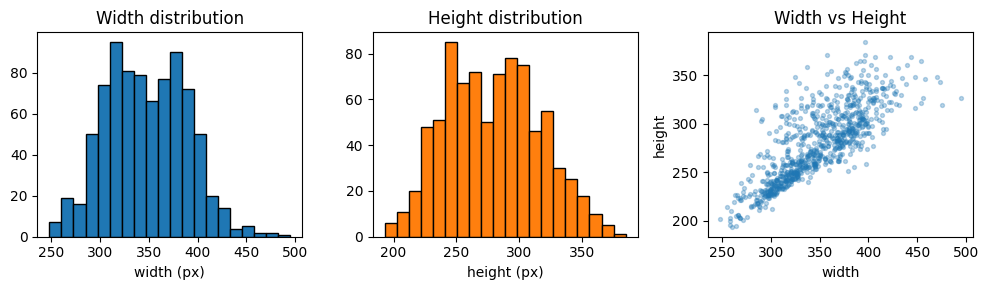


Aggregate per-group technical stats:
   group  n_images  mean_img_mean  std_img_mean  mean_img_std  median_contrast  mean_min  mean_max
     GOT       226         31.261         4.935        32.127          246.000     0.889   246.164
     GPT       215         31.005         4.356        33.248          247.000     0.828   246.949
 Control       205         28.822         6.465        32.728          249.000     0.166   243.951
Combined       178         29.251         5.687        33.119          249.000     0.067   247.506

Pairwise Cohen's d (img_mean) between groups — sorted by |d|:
 Control vs GOT: d=-0.4267985809547486 (n=205,226)
 Control vs GPT: d=-0.3978309760120558 (n=205,215)
 Combined vs GOT: d=-0.38079767552395616 (n=178,226)
 Combined vs GPT: d=-0.3507721170788744 (n=178,215)
 Combined vs Control: d=0.070058774870099 (n=178,205)
 GOT vs GPT: d=0.05480359396872427 (n=226,215)


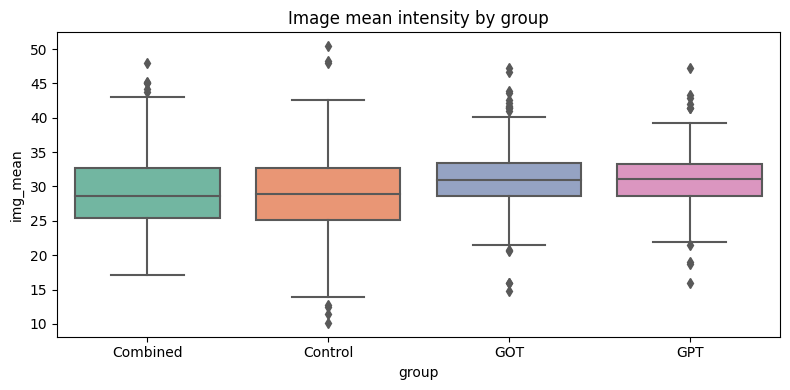

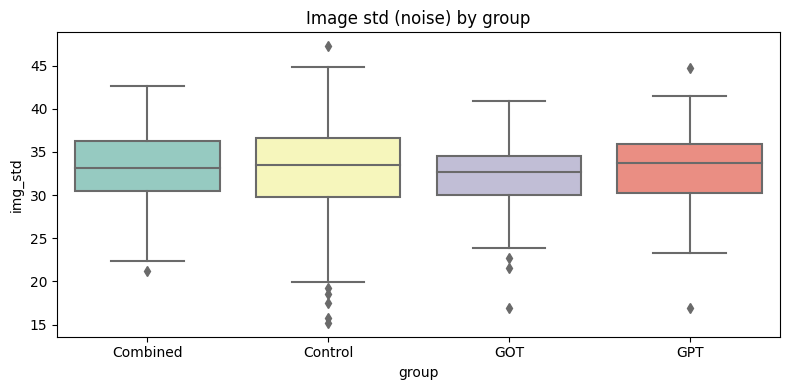


Per-subject summary (top 10 by n_images):
subject_id  n_images  mean_of_means  std_of_means  mean_img_std  min_min  max_max  z_mean  z_noise
     GOT 7        28         31.611         2.969        32.574    0.000  255.000   0.279   -0.070
    GOT 10        28         30.135         6.273        29.383    0.000  255.000  -0.181   -1.424
     GPT 2        28         31.123         5.120        32.085    0.000  255.000   0.127   -0.277
 Control 4        28         29.719         5.386        31.119    0.000  254.000  -0.310   -0.687
 Control 3        28         28.136         6.540        31.665    0.000  255.000  -0.803   -0.456
 Control 5        26         30.594         5.460        35.588    0.000  254.000  -0.038    1.209
     GOT 9        26         32.581         4.277        33.099    0.000  255.000   0.581    0.153
 Control 2        25         31.640         8.001        37.600    0.000  255.000   0.288    2.063
     GOT 8        25         30.297         5.790        32.715   

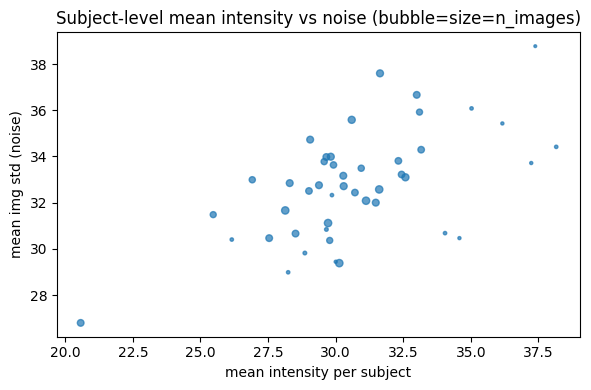


Done — reviewed sizes, group-level technical stats, and subject-level outliers.


In [10]:
#analytical checks — size distribution, group comparison, per-subject stats
import math
from PIL import Image, UnidentifiedImageError
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# -- helpers --------------------------------------------------------------
def ensure_resolved_paths(df):
    path_candidates = ["file_path","filepath","relative_path","path","image_path","filename","file"]
    cols_lower = [c.lower() for c in df.columns]
    meta_path_col = None
    for c in path_candidates:
        if c in cols_lower:
            meta_path_col = df.columns[cols_lower.index(c)]
            break
    if meta_path_col is None:
        raise RuntimeError("No recognized file/path column in metadata. Add one of: " + ", ".join(path_candidates))
    if "_resolved_path" not in df.columns:
        def _resolve(v):
            if pd.isna(v):
                return None
            p = Path(str(v))
            if not p.is_absolute():
                p = data_raw_dir / p
            return p
        df["_resolved_path"] = df[meta_path_col].apply(_resolve)
    return df

def compute_image_basic_stats(df, cols_exist=("img_min","img_max","img_mean","img_std")):
    need = any(c not in df.columns for c in cols_exist)
    if not need:
        return df
    mins, maxs, means, stds = [], [], [], []
    for p in df["_resolved_path"]:
        if p is None or not Path(p).exists():
            mins.append(np.nan); maxs.append(np.nan); means.append(np.nan); stds.append(np.nan)
            continue
        try:
            im = Image.open(p).convert("L")
            a = np.asarray(im, dtype=np.float32)
            mins.append(float(np.nanmin(a))); maxs.append(float(np.nanmax(a)))
            means.append(float(np.nanmean(a))); stds.append(float(np.nanstd(a, ddof=0)))
        except Exception:
            mins.append(np.nan); maxs.append(np.nan); means.append(np.nan); stds.append(np.nan)
    df["img_min"], df["img_max"], df["img_mean"], df["img_std"] = mins, maxs, means, stds
    return df

def load_size(p):
    try:
        im = Image.open(p)
        return im.size  # (width, height)
    except Exception:
        return (np.nan, np.nan)

# -- prepare dataframe ---------------------------------------------------
df = ensure_resolved_paths(df)
df = compute_image_basic_stats(df)

# 1) Size distribution (W,H)
sizes = [load_size(p) if p is not None else (np.nan,np.nan) for p in df["_resolved_path"]]
sizes_df = pd.DataFrame(sizes, columns=["width","height"])
df_sizes = pd.concat([df.reset_index(drop=True), sizes_df], axis=1)

shape_counts = df_sizes.dropna(subset=["width","height"]).groupby(["width","height"]).size().reset_index(name="count").sort_values("count", ascending=False)
print("\nUnique image shapes (width x height) — top 10:")
print(shape_counts.head(10).to_string(index=False))

# Quick plots: histogram of widths and heights, scatter W vs H
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(df_sizes["width"].dropna(), bins=20, color="C0", edgecolor="k")
plt.xlabel("width (px)"); plt.title("Width distribution")
plt.subplot(1,3,2)
plt.hist(df_sizes["height"].dropna(), bins=20, color="C1", edgecolor="k")
plt.xlabel("height (px)"); plt.title("Height distribution")
plt.subplot(1,3,3)
plt.scatter(df_sizes["width"], df_sizes["height"], alpha=0.3, s=8)
plt.xlabel("width"); plt.ylabel("height"); plt.title("Width vs Height")
plt.tight_layout(); plt.show()

# 2) Comparison between study groups (contrast/brightness/noise/range)
df_sizes["contrast"] = df_sizes["img_max"] - df_sizes["img_min"]
group_agg = df_sizes.groupby("group").agg(
    n_images = ("img_mean","count"),
    mean_img_mean = ("img_mean","mean"),
    std_img_mean = ("img_mean","std"),
    mean_img_std = ("img_std","mean"),
    median_contrast = ("contrast","median"),
    mean_min = ("img_min","mean"),
    mean_max = ("img_max","mean")
).reset_index().sort_values("n_images", ascending=False)

pd.set_option("display.float_format", lambda x: f"{x:.3f}")
print("\nAggregate per-group technical stats:")
print(group_agg.to_string(index=False))

# Pairwise Cohen's d for img_mean between groups (quick effect sizes)
def cohen_d(a,b):
    a = np.asarray(a)[~np.isnan(a)]; b = np.asarray(b)[~np.isnan(b)]
    if len(a) < 2 or len(b) < 2: return np.nan
    da = a.mean()-b.mean()
    sa = a.var(ddof=1); sb = b.var(ddof=1)
    pooled = math.sqrt(((len(a)-1)*sa + (len(b)-1)*sb) / (len(a)+len(b)-2))
    if pooled == 0: return np.nan
    return da/pooled

groups = df_sizes["group"].dropna().unique()
pairs = []
for i,g1 in enumerate(groups):
    for g2 in groups[i+1:]:
        a = df_sizes[df_sizes["group"]==g1]["img_mean"]
        b = df_sizes[df_sizes["group"]==g2]["img_mean"]
        d = cohen_d(a,b)
        pairs.append((g1,g2,d,len(a.dropna()),len(b.dropna())))
pairs = sorted(pairs, key=lambda x: (math.isnan(x[2]), -abs(x[2]) if not math.isnan(x[2]) else 0))
print("\nPairwise Cohen's d (img_mean) between groups — sorted by |d|:")
for g1,g2,d,na,nb in pairs:
    print(f" {g1} vs {g2}: d={d if not math.isnan(d) else 'nan'} (n={na},{nb})")

# Boxplots for visual comparison
try:
    import seaborn as sns
    plt.figure(figsize=(8,4))
    sns.boxplot(x="group", y="img_mean", data=df_sizes, palette="Set2")
    plt.title("Image mean intensity by group"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,4))
    sns.boxplot(x="group", y="img_std", data=df_sizes, palette="Set3")
    plt.title("Image std (noise) by group"); plt.tight_layout(); plt.show()
except Exception:
    # fallback simple boxplots
    grp_order = sorted(df_sizes["group"].dropna().unique())
    vals = [df_sizes[df_sizes["group"]==g]["img_mean"].dropna().values for g in grp_order]
    plt.figure(figsize=(8,4)); plt.boxplot(vals, labels=grp_order); plt.title("img_mean by group"); plt.tight_layout(); plt.show()

# 3) Statistics by subject — find outliers
subj_agg = df_sizes.groupby("subject_id").agg(
    n_images=("img_mean","count"),
    mean_of_means=("img_mean","mean"),
    std_of_means=("img_mean","std"),
    mean_img_std=("img_std","mean"),
    min_min = ("img_min","min"),
    max_max = ("img_max","max")
).reset_index()

# flag outliers by z-score on mean_of_means and mean_img_std
subj_agg["z_mean"] = (subj_agg["mean_of_means"] - subj_agg["mean_of_means"].mean()) / (subj_agg["mean_of_means"].std(ddof=0) + 1e-12)
subj_agg["z_noise"] = (subj_agg["mean_img_std"] - subj_agg["mean_img_std"].mean()) / (subj_agg["mean_img_std"].std(ddof=0) + 1e-12)

outliers_mean = subj_agg[np.abs(subj_agg["z_mean"]) > 3].sort_values("z_mean", key=lambda s: np.abs(s), ascending=False)
outliers_noise = subj_agg[np.abs(subj_agg["z_noise"]) > 3].sort_values("z_noise", key=lambda s: np.abs(s), ascending=False)

print("\nPer-subject summary (top 10 by n_images):")
print(subj_agg.sort_values("n_images", ascending=False).head(10).to_string(index=False))

print(f"\nSubjects with extreme mean intensity (|z|>3): {len(outliers_mean)}")
if not outliers_mean.empty:
    print(outliers_mean.to_string(index=False))

print(f"\nSubjects with extreme noise (img_std) (|z|>3): {len(outliers_noise)}")
if not outliers_noise.empty:
    print(outliers_noise.to_string(index=False))

# Quick scatter to inspect subjects
plt.figure(figsize=(6,4))
plt.scatter(subj_agg["mean_of_means"], subj_agg["mean_img_std"], s=np.clip(subj_agg["n_images"],1,50), alpha=0.7)
plt.xlabel("mean intensity per subject"); plt.ylabel("mean img std (noise)")
plt.title("Subject-level mean intensity vs noise (bubble=size=n_images)")
plt.tight_layout(); plt.show()

# done
print("\nDone — reviewed sizes, group-level technical stats, and subject-level outliers.")

### Summery of analytical checks 
**part 1 - Size Distribution**  
 - ***What did we find?***
No fixed size — no 256×256 format or other uniform size.
Each Width×Height pair appeared exactly 2 times
    - The format of the images is not standard.
    - There is a significant spread in both width and height.
    - From the graph you can see a strong linear relationship between width and height. All images are in the same proportion, but with varying resolution.

part 1 conclutions: ***Uniform Resize Required***

**part 2 - Comparison Between Study Groups** 
 - ***What did we test?***
    - Average brightness intensity (img_mean)
    - Standard deviation of intensity (img_std = proxy for noise)
    - Contrast = img_max − img_min
    - Comparison of groups using Cohen’s d

 - part 2 Results and Conclutions : 
    - According to Mean intensity -
    GOT and GPT groups are brighter than Control and Combined.

    - According to Noise (img_std)
    GOT group is better quality (low noise).
    GPT group is a little noisier.

    - Contrast (range of values):
    All groups received very high Contrast (≈ 246–249), completely consistent.

    - According to Cohen's d — did we check whether the groups differ from each other?
    The results came out like this - there is a relatively significant difference between Control/Combined and GOT/GPT groups
 - ***Meaning***:
   **Need to normalize intensity** before training a model. There is variation between groups, the model may “understand” group and not pathology if we do not normalize.
   
**part 3 - Per-Subject Statistics / Outliers**
   - ***What did we test?***
      For each mouse:
      mean intensity, noise, slice-to-slice variation, Z-score anomaly detection
   - ***What are the results and implications we found:***
   
      Only one clear outlier: **control 1**.
      
      According to the calculation metrics - mean_of_means, z_mean , mean_img_std
      The data we got is very low and out of the ordinary.

      Some possible reasons:
      1. Dark images (consistent with the visual EDA)
      2. Maybe an acquisition problem in the device
      3. Maybe a different brain slice position
      4. Not similar to all the other mice
      
**part 4 - Visual Comparison (boxplots & scatter)**
   1) Boxplots of img_mean
      - GOT and GPT are brighter as expected.
      - Control & Combined are slightly darker.

   2) Boxplots of img_std
      - Consistent noise across all groups, but GPT is slightly noisier.

   3) Scatter subject-level mean vs noise
      - Natural scatter, no suspicious structure.
      - Subject Control 1 is far from the cloud.

 


